In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/navigation NCLT dataset
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device  # For backward compatibility
print(f"device: {device}")

device: cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import Systems


# Parametry sekvencí
TRAIN_SEQ_LEN = 100       # Délka sekvence pro trénink (např. 100 kroků = 100 sekund při 1Hz)
VAL_SEQ_LEN = 400
TEST_SEQ_LEN = 1000      # Délka sekvence pro testování (delší sekvence pro stabilnější vyhodnocení)
STRIDE = 20         # Posun okna (překryv) pro data augmentation
BATCH_SIZE = 256
DATA_PATH = 'data/processed'
print(f"Běží na zařízení: {device}")

Běží na zařízení: cuda


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os

def prepare_sequences(dataset_list, seq_len, stride, mode='train'):
    """
    Zpracuje list trajektorií na sekvence pro trénink dle článku.
    
    Nový formát dle [Song et al., 2024]:
    - Vstup u (4D): [v_left, v_right, theta_imu, omega_imu]
    - Cíl x (6D):   [px, py, vx, vy, theta, omega]
    """
    X_seq_list = [] # Ground Truth (Cíl)
    Y_seq_list = [] # GPS Měření (Vstup do korekce)
    U_seq_list = [] # Control Input (IMU/Odo)
    
    print(f"Zpracovávám {len(dataset_list)} trajektorií pro {mode}...")
    
    for traj in dataset_list:
        # 1. Extrahuje data
        # GT z preprocessingu je [px, py, theta]
        gt = traj['ground_truth'].float() 
        
        # GPS: [x, y] (obsahuje NaN!)
        gps = traj['filtered_gps'].float()
        
        # IMU: [ax, ay, theta, omega]
        imu = traj['imu'].float()
        theta_imu = imu[:, 2] # Orientace z IMU
        omega_imu = imu[:, 3] # Úhlová rychlost z IMU
        
        # ODO: [v_left, v_right]
        odo = traj['filtered_wheel'].float()
        
        # Fix NaN v odometrii (nahradíme nulou)
        v_left = torch.nan_to_num(odo[:, 0], nan=0.0)
        v_right = torch.nan_to_num(odo[:, 1], nan=0.0)
        
        # 2. Sestavení vstupu u = [v_l, v_r, theta_imu, omega_imu] (4D)
        # Toto odpovídá "State Model" definovanému v článku (sekce II.C.2)
        u = torch.stack((v_left, v_right, theta_imu, omega_imu), dim=1)
        
        # 3. Sestavení cíle x (6D) pro state vector [px, py, vx, vy, theta, omega]
        # Vyplníme to, co máme z Ground Truth (px, py, theta).
        # Rychlosti (vx, vy, omega) v GT implicitně nemáme (nebo je složité je derivovat přesně),
        # ale pro trénink Loss funkce budeme stejně porovnávat primárně pozici.
        T = gt.shape[0]
        x_target = torch.zeros(T, 6)
        x_target[:, 0] = gt[:, 0] # px
        x_target[:, 1] = gt[:, 1] # py
        x_target[:, 4] = gt[:, 2] # theta
        # Ostatní (vx, vy, omega) zůstávají 0, protože v Loss funkci budeme maskovat nebo brát jen pozici.
        
        # 4. Sliding Window (Rozsekání na sekvence)
        num_samples = gt.shape[0]
        current_stride = stride if mode == 'train' else seq_len # U testu bez překryvu
        
        for i in range(0, num_samples - seq_len + 1, current_stride):
            # Cíl: 6D stav
            x_seq = x_target[i : i+seq_len, :]
            
            # Měření: GPS [px, py]
            y_seq = gps[i : i+seq_len, :]
            
            # Vstup: 4D control input
            u_seq = u[i : i+seq_len, :]
            
            X_seq_list.append(x_seq)
            Y_seq_list.append(y_seq)
            U_seq_list.append(u_seq)
            
    # Stack do tenzorů
    X_out = torch.stack(X_seq_list)
    Y_out = torch.stack(Y_seq_list)
    U_out = torch.stack(U_seq_list)
    
    return X_out, Y_out, U_out

# === NAČTENÍ DAT ===
# Ujistíme se, že cesty a konstanty jsou definované (pokud nejsou, doplňte je nahoře)
# if 'DATA_PATH' not in locals(): DATA_PATH = 'data/processed'
# if 'TRAIN_SEQ_LEN' not in locals(): TRAIN_SEQ_LEN = 100
# if 'VAL_SEQ_LEN' not in locals(): VAL_SEQ_LEN = 200
# if 'TEST_SEQ_LEN' not in locals(): TEST_SEQ_LEN = 500
# if 'STRIDE' not in locals(): STRIDE = 20
# if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 256

train_data_raw = torch.load(os.path.join(DATA_PATH, 'train.pt'))
val_data_raw = torch.load(os.path.join(DATA_PATH, 'val.pt'))
test_data_raw = torch.load(os.path.join(DATA_PATH, 'test.pt'))

# === PŘÍPRAVA SEKVENCÍ ===
print("--- Generuji trénovací data (Paper compatible) ---")
train_X, train_Y, train_U = prepare_sequences(train_data_raw, TRAIN_SEQ_LEN, STRIDE, 'train')

print("\n--- Generuji validační data ---")
val_X, val_Y, val_U = prepare_sequences(val_data_raw, VAL_SEQ_LEN, VAL_SEQ_LEN, 'val')

print("\n--- Generuji testovací data ---")
test_X, test_Y, test_U = prepare_sequences(test_data_raw, TEST_SEQ_LEN, TEST_SEQ_LEN, 'test')

# Vytvoření DataLoaderů
train_loader = DataLoader(TensorDataset(train_X, train_Y, train_U), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_Y, val_U), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(test_X, test_Y, test_U), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ Data připravena.")
print(f"Train batches: {len(train_loader)}")
print(f"Shapes -> X: {train_X.shape} (6D State), U: {train_U.shape} (4D Input), Y: {train_Y.shape} (2D Meas)")

--- Generuji trénovací data (Paper compatible) ---
Zpracovávám 22 trajektorií pro train...

--- Generuji validační data ---
Zpracovávám 2 trajektorií pro val...

--- Generuji testovací data ---
Zpracovávám 3 trajektorií pro test...

✅ Data připravena.
Train batches: 22
Shapes -> X: torch.Size([5446, 100, 6]) (6D State), U: torch.Size([5446, 100, 4]) (4D Input), Y: torch.Size([5446, 100, 2]) (2D Meas)


In [5]:
# === INICIALIZACE DYNAMICKÉHO MODELU (System Instance - Paper Version) ===

# 1. Parametry systému podle článku [Song et al., 2024]
# State (6D): [px, py, vx, vy, theta, omega]
# Referenční rovnice (5) v článku.
state_dim = 6
# Meas (2D):  [gps_x, gps_y]
# Referenční rovnice (6) v článku.
obs_dim = 2
# Časový krok (z preprocessingu)
dt = 1.0  

# 2. Definice Matice Q (Procesní šum / Model Uncertainty)
# Nyní máme 6 stavů. Musíme definovat nejistotu pro každý z nich.
# Hodnoty jsou nastaveny heuristicky (lze ladit):
# - Pozice (idx 0,1): 0.1
# - Rychlost (idx 2,3): 0.1
# - Úhel/Omega (idx 4,5): 0.01 (IMU je v NCLT docela přesné, ale driftuje)
q_diag = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])
Q = torch.diag(q_diag)

# 3. Definice Matice R (Šum měření / Sensor Noise)
# GPS měří jen pozici (px, py).
# Nastavujeme 1.0 m^2. To odpovídá standardní odchylce 1m.
# Pokud je GPS v datasetu horší, KalmanNet se naučí "nedůvěřovat" vstupu y
# a spoléhat více na predikci z u (odometrie).
r_diag = torch.tensor([1.0, 1.0])
R = torch.diag(r_diag)

# 4. Počáteční podmínky (Prior)
# Ex0: Nulový vektor 6x1
Ex0 = torch.zeros(state_dim, 1)

# P0: Počáteční kovariance
# Autoři používají P k inicializaci EKF[cite: 700].
# Nastavíme rozumnou počáteční nejistotu.
P0 = torch.eye(state_dim) * 0.5

# 5. Vytvoření instance DynamicSystemNCLT
# Důležité: f=None zajistí, že se použije interní `_f_paper_dynamics` (rovnice 5),
# která očekává 4D vstup (v_l, v_r, theta, omega).
sys_model = Systems.DynamicSystemNCLT(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q,
    R=R,
    Ex0=Ex0,
    P0=P0,
    dt=dt,
    f=None,  # None -> Použije se model z článku: px += vc*cos(theta_imu)...
    h=None,  # None -> Použije se GPS model: y = [px, py]
    device=DEVICE
)

print(f"✅ System Model NCLT inicializován (Paper Version).")
print(f" - State Dim: {sys_model.state_dim} [px, py, vx, vy, theta, omega]")
print(f" - Meas Dim:  {sys_model.obs_dim} [gps_x, gps_y]")
print(f" - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]") # Implicitně v modelu
print(f" - Q Diag: {q_diag.tolist()}")

✅ System Model NCLT inicializován (Paper Version).
 - State Dim: 6 [px, py, vx, vy, theta, omega]
 - Meas Dim:  2 [gps_x, gps_y]
 - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]
 - Q Diag: [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.009999999776482582, 0.009999999776482582]


In [6]:
import torch
import torch.optim as optim
import os
from state_NN_models import StateKalmanNet
from utils import trainer

# === 1. KONFIGURACE A INICIALIZACE MODELU ===

# Hyperparametry sítě
# State dim je 3. Multiplier 40 znamená hidden state velikosti 120.
# To je pro navigaci s nelinearitami (sin/cos) rozumná kapacita.
print("Inicializuji StateKalmanNet...")
state_knet = StateKalmanNet(
    system_model=sys_model,
    device=DEVICE,
    hidden_size_multiplier=6,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    gru_hidden_dim_multiplier=6
).to(DEVICE)
print(state_knet)

# Počet trénovatelných parametrů
params_count = sum(p.numel() for p in state_knet.parameters() if p.requires_grad)
print(f"Model má {params_count} trénovatelných parametrů.")

# === 2. NASTAVENÍ TRÉNINKU (TBPTT) ===

# Parametry pro Sliding Window trénink (TBPTT)
# NCLT sekvence jsou dlouhé (100 kroků), gradienty by mohly explodovat.
# Dělíme je na okna délky 20 a gradienty ořezáváme.
TBPTT_WINDOW = 8  # Délka okna (w)
TBPTT_STEP = 2    # Krok pro detach (k) - obvykle polovina w

EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4 # Jemná regularizace
CLIP_GRAD = 1.0    # Důležité: Ořezání gradientů pro stabilitu RNN

# === 3. SPUŠTĚNÍ TRÉNINKU ===
print("\n🚀 Spouštím tréninkovou smyčku...")

trained_knet = trainer.train_state_KalmanNet_sliding_windowNCLT(
    model=state_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    weight_decay_=WEIGHT_DECAY,
    clip_grad=CLIP_GRAD,
    early_stopping_patience=20, # Zastaví, pokud se 20 epoch nezlepší loss
    tbptt_k=TBPTT_STEP,
    tbptt_w=TBPTT_WINDOW
)

# === 4. ULOŽENÍ MODELU ===
save_path = 'best_kalmannet_nclt_sensor_fusion.pth'
torch.save(trained_knet.state_dict(), save_path)
print(f"\n✅ Trénink dokončen. Nejlepší model uložen do: {save_path}")

Inicializuji StateKalmanNet...
DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=384, bias=True)
      (1): ReLU()
    )
    (gru): GRU(384, 240)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=240, out_features=48, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=48, out_features=12, bias=True)
    )
  )
)
Model má 469404 trénovatelných parametrů.

🚀 Spouštím tréninkovou smyčku...
INFO: Starting training with TBPTT(k=2, w=8)
INFO: Returns covariance: False
Epoch [1/100] | Train Loss: 8.0679 | Val Loss: 24.1920
 -> New best model saved! (Val Loss: 24.1920)
Epoch [2/100] | Train Loss: 6.2289 | Val Loss: 20.1535
 -> New best model saved! (Val Loss: 20.1535)
Epoch [3/100] | Train Loss: 5.2619 | Val Loss: 14.1424
 -> New best model saved! (Val Loss: 14.1424)
Epoch [4/100] | Tra

INFO: Nastaveno sys_model.dt = 1.0 s

Spouštím detailní evaluaci na 3 trajektoriích...

------------------------------------------------------------
VÝSLEDKY: TRAJEKTORIE 1 (Délka: 4835 kroků)
------------------------------------------------------------
Metoda               | MSE             | RMSE           
------------------------------------------------------------
GPS (Valid Only)     | 164.46          | 12.82          
GPS (Authors)        | 2114.17         | 45.98          
------------------------------------------------------------
EKF (Full)           | 443.11          | 21.05          
UKF (Full)           | 440.44          | 20.99          
KNet (Full)          | 189.09          | 13.75          
------------------------------------------------------------


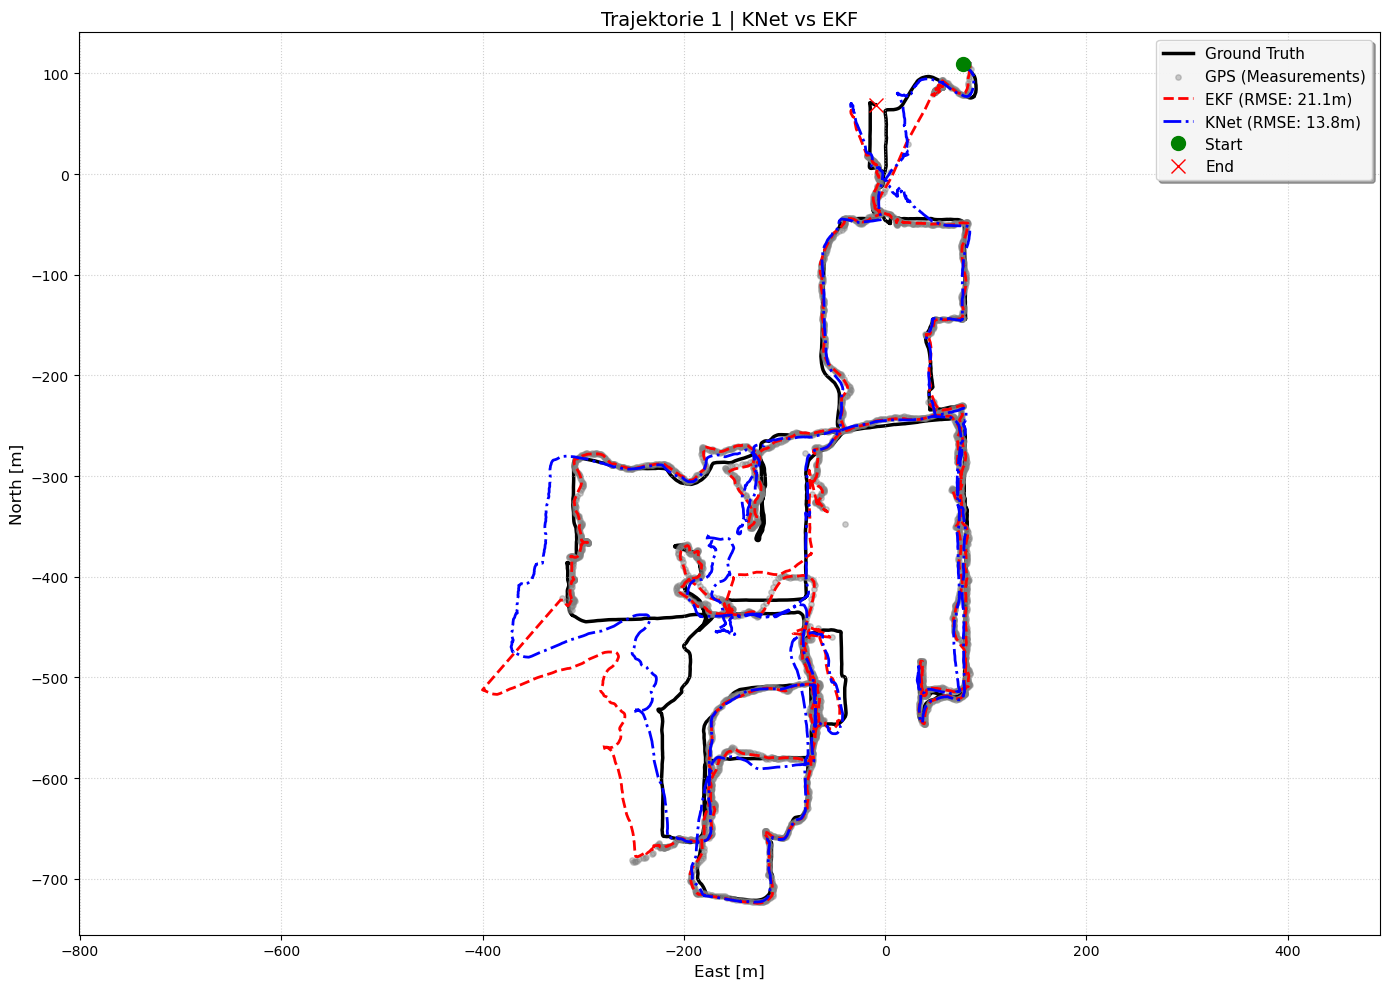


------------------------------------------------------------
VÝSLEDKY: TRAJEKTORIE 2 (Délka: 4918 kroků)
------------------------------------------------------------
Metoda               | MSE             | RMSE           
------------------------------------------------------------
GPS (Valid Only)     | 51.13           | 7.15           
GPS (Authors)        | 375.98          | 19.39          
------------------------------------------------------------
EKF (Full)           | 221.68          | 14.89          
UKF (Full)           | 221.82          | 14.89          
KNet (Full)          | 38.98           | 6.24           
------------------------------------------------------------


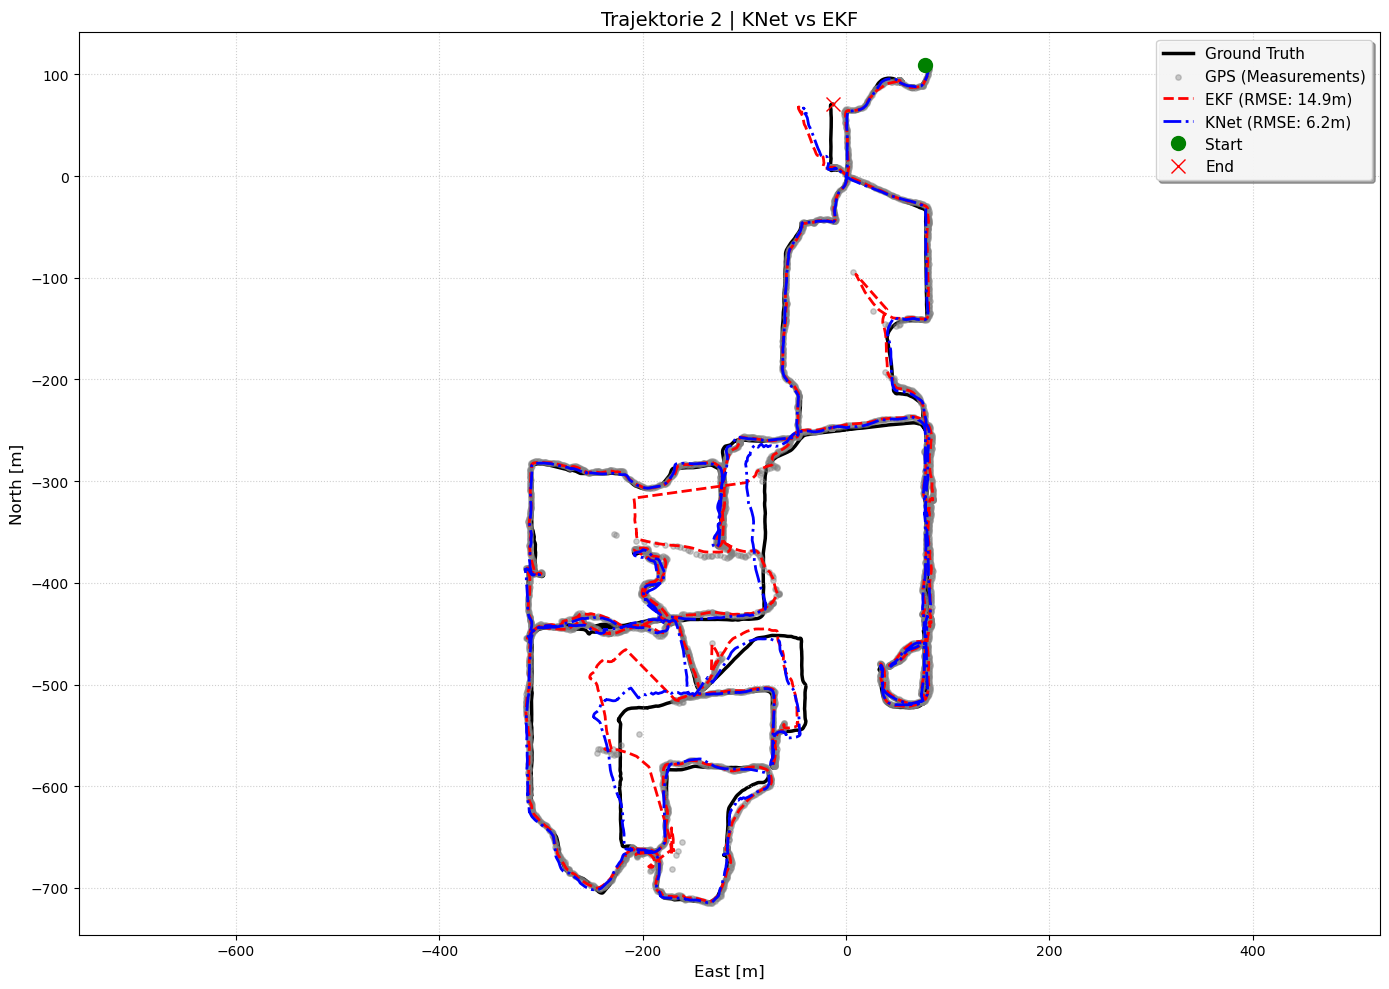


------------------------------------------------------------
VÝSLEDKY: TRAJEKTORIE 3 (Délka: 4183 kroků)
------------------------------------------------------------
Metoda               | MSE             | RMSE           
------------------------------------------------------------
GPS (Valid Only)     | 39.94           | 6.32           
GPS (Authors)        | 1185.49         | 34.43          
------------------------------------------------------------
EKF (Full)           | 128.44          | 11.33          
UKF (Full)           | 128.70          | 11.34          
KNet (Full)          | 35.53           | 5.96           
------------------------------------------------------------


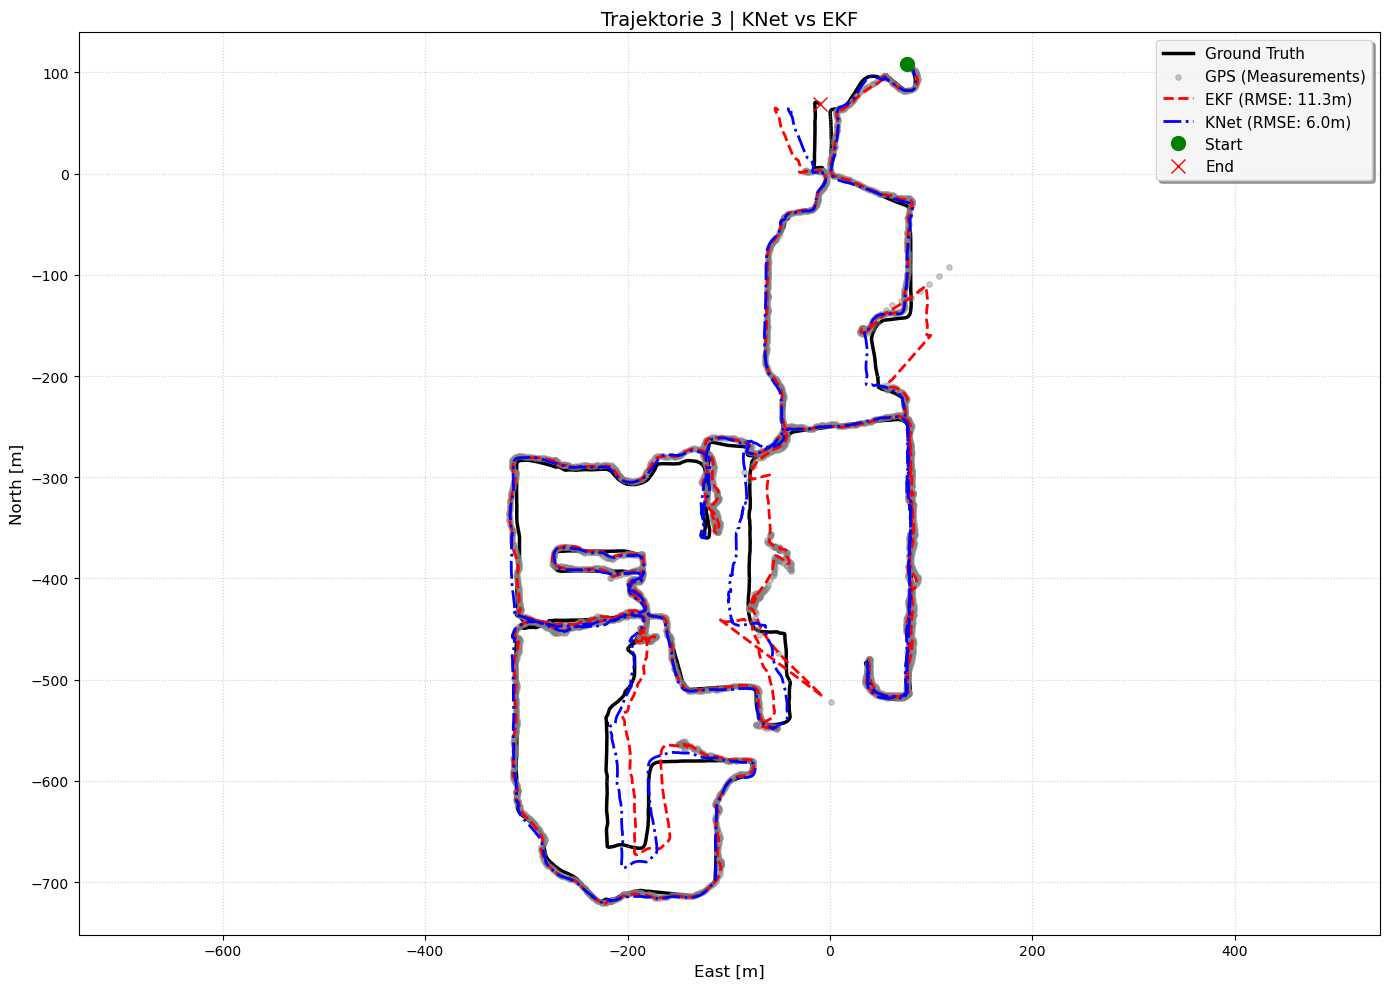


FINÁLNÍ PRŮMĚRNÉ VÝSLEDKY (3 trajektorií)
Metoda               | MSE (Sensor)    | RMSE (Sensor)   | MSE (Full)      | RMSE (Full)    
----------------------------------------------------------------------------------------------------
GPS (Valid Only)     | 85.18           | 9.23            | -               | -              
GPS (Authors)        | -               | -               | 1225.21         | 35.00          
----------------------------------------------------------------------------------------------------
EKF                  | -               | -               | 264.41          | 16.26          
UKF                  | -               | -               | 263.66          | 16.24          
KNet                 | -               | -               | 87.87           | 9.37           


In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import Filters

# ==============================================================================
# 0. KONFIGURACE A MODEL
# ==============================================================================
DT_SEC = 1.0 
if hasattr(sys_model, 'dt'):
    sys_model.dt = DT_SEC
    print(f"INFO: Nastaveno sys_model.dt = {DT_SEC} s")

# Načtení modelu
try:
    trained_model_classic = state_knet
    trained_model_classic.eval()
except NameError:
    raise NameError("Chyba: 'state_knet' neexistuje.")

# Inicializace filtrů
ukf_filter = Filters.UnscentedKalmanFilter(sys_model) 
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)

# ==============================================================================
# 1. EVALUACE A VIZUALIZACE
# ==============================================================================
results = {
    'GPS_Sensor': [],   # Masked (Tvoje původní - přesnost senzoru)
    'GPS_Authors': [],  # Filled (Autoři - Nearest Neighbor penalizace)
    'EKF_Full': [],
    'UKF_Full': [],
    'KNet_Full': []
}

print(f"\nSpouštím detailní evaluaci na {len(test_data_raw)} trajektoriích...")

for i, traj in enumerate(test_data_raw):
    # --- PŘÍPRAVA DAT ---
    gt_raw = traj['ground_truth'].float().to(DEVICE)
    
    # Dva druhy GPS dat:
    gps_filtered = traj['filtered_gps'].float().to(DEVICE) # S NaNs (pro EKF update)
    gps_filled = traj['gps'].float().to(DEVICE)            # Bez NaNs (pro metriku autorů)
    
    imu_raw = traj['imu'].float().to(DEVICE)
    odo_raw = traj['filtered_wheel'].float().to(DEVICE)
    
    T_len = gt_raw.shape[0]
    
    # Vstupy (Control Input) [T, 4]
    u_full = torch.stack((
        torch.nan_to_num(odo_raw[:, 0], nan=0.0),
        torch.nan_to_num(odo_raw[:, 1], nan=0.0),
        imu_raw[:, 2], 
        imu_raw[:, 3]
    ), dim=1).to(DEVICE)
    
    # KNet Vstupy (KNet nesmí vidět NaN v měření, nahradíme nulou)
    u_knet = u_full.clone()

    # Filter Inputs (EKF umí přeskočit NaN)
    y_filter = gps_filtered
    
    # Init
    x_true = gt_raw[:, :3]
    m = sys_model.state_dim
    x0_vec = torch.zeros(m).to(DEVICE)
    x0_vec[0] = x_true[0, 0]; x0_vec[1] = x_true[0, 1]
    if m >= 3: x0_vec[-1] = x_true[0, 2]
    x0_knet = x0_vec.unsqueeze(0)

    # --- BĚH MODELŮ ---
    
    # A. KalmanNet
    trained_model_classic.reset(batch_size=1, initial_state=x0_knet)
    knet_path = [x0_knet]
    with torch.no_grad():
        for t in range(1, T_len):
            x_est = trained_model_classic.step(y_filter[t].unsqueeze(0), u_knet[t].unsqueeze(0))
            knet_path.append(x_est)
    x_knet = torch.cat(knet_path, dim=0)

    # B. EKF
    try:
        res_ekf = ekf_filter.process_sequence(y_filter, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
        x_ekf = res_ekf['x_filtered']
    except Exception as e:
        x_ekf = torch.zeros((T_len, m)).to(DEVICE)

    # C. UKF
    try:
        res_ukf = ukf_filter.process_sequence(y_filter, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
        x_ukf = res_ukf['x_filtered']
    except Exception as e:
        x_ukf = torch.zeros((T_len, m)).to(DEVICE)

    # --- METRIKY ---
    def get_mse(pred, target, mask=None):
        if mask is not None:
            if mask.sum() == 0: return float('nan')
            return F.mse_loss(pred[mask, :2], target[mask, :2]).item()
        return F.mse_loss(pred[:, :2], target[:, :2]).item()

    # 1. GPS Sensor (Masked)
    mask_valid = ~torch.isnan(gps_filtered[:, 0])
    mse_gps_sensor = get_mse(gps_filtered, x_true, mask_valid)
    
    # 2. GPS Authors (Filled)
    mse_gps_authors = get_mse(gps_filled, x_true)
    
    # 3. Filtry (Full)
    mse_ekf = get_mse(x_ekf, x_true)
    mse_ukf = get_mse(x_ukf, x_true)
    mse_knet = get_mse(x_knet, x_true)

    # Ukládání
    results['GPS_Sensor'].append(mse_gps_sensor)
    results['GPS_Authors'].append(mse_gps_authors)
    results['EKF_Full'].append(mse_ekf)
    results['UKF_Full'].append(mse_ukf)
    results['KNet_Full'].append(mse_knet)

    # --- VÝPIS PRO JEDNOTLIVOU TRAJEKTORII ---
    print(f"\n" + "-"*60)
    print(f"VÝSLEDKY: TRAJEKTORIE {i+1} (Délka: {T_len} kroků)")
    print("-" * 60)
    print(f"{'Metoda':<20} | {'MSE':<15} | {'RMSE':<15}")
    print("-" * 60)
    print(f"{'GPS (Valid Only)':<20} | {mse_gps_sensor:<15.2f} | {np.sqrt(mse_gps_sensor):<15.2f}")
    print(f"{'GPS (Authors)':<20} | {mse_gps_authors:<15.2f} | {np.sqrt(mse_gps_authors):<15.2f}")
    print("-" * 60)
    print(f"{'EKF (Full)':<20} | {mse_ekf:<15.2f} | {np.sqrt(mse_ekf):<15.2f}")
    print(f"{'UKF (Full)':<20} | {mse_ukf:<15.2f} | {np.sqrt(mse_ukf):<15.2f}")
    print(f"{'KNet (Full)':<20} | {mse_knet:<15.2f} | {np.sqrt(mse_knet):<15.2f}")
    print("-" * 60)

    # --- VIZUALIZACE ---
    gt_np = x_true.cpu().numpy()
    gps_valid_np = gps_filtered.cpu().numpy()
    ekf_np = x_ekf.cpu().numpy()
    knet_np = x_knet.cpu().numpy()

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.plot(gt_np[:, 0], gt_np[:, 1], 'k-', linewidth=2.5, label='Ground Truth', zorder=1)
    
    valid_idx = ~np.isnan(gps_valid_np[:, 0])
    ax.scatter(gps_valid_np[valid_idx, 0], gps_valid_np[valid_idx, 1], 
               c='gray', s=15, alpha=0.4, label='GPS (Measurements)', zorder=2)
    
    ax.plot(ekf_np[:, 0], ekf_np[:, 1], 'r--', linewidth=2, 
            label=f'EKF (RMSE: {np.sqrt(mse_ekf):.1f}m)', zorder=3)
    ax.plot(knet_np[:, 0], knet_np[:, 1], 'b-.', linewidth=2, 
            label=f'KNet (RMSE: {np.sqrt(mse_knet):.1f}m)', zorder=4)

    ax.plot(gt_np[0, 0], gt_np[0, 1], 'go', markersize=10, label='Start', zorder=5)
    ax.plot(gt_np[-1, 0], gt_np[-1, 1], 'rx', markersize=10, label='End', zorder=5)

    ax.set_title(f"Trajektorie {i+1} | KNet vs EKF", fontsize=14)
    ax.set_xlabel('East [m]', fontsize=12)
    ax.set_ylabel('North [m]', fontsize=12)
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9, shadow=True)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 2. FINÁLNÍ SOUHRNNÁ TABULKA
# ==============================================================================
print("\n" + "="*100)
print(f"FINÁLNÍ PRŮMĚRNÉ VÝSLEDKY ({len(test_data_raw)} trajektorií)")
print("="*100)
print(f"{'Metoda':<20} | {'MSE (Sensor)':<15} | {'RMSE (Sensor)':<15} | {'MSE (Full)':<15} | {'RMSE (Full)':<15}")
print("-" * 100)

def smm(key): return np.nanmean(results[key])

mse_s = smm('GPS_Sensor')
mse_a = smm('GPS_Authors')
print(f"{'GPS (Valid Only)':<20} | {mse_s:<15.2f} | {np.sqrt(mse_s):<15.2f} | {'-':<15} | {'-':<15}")
print(f"{'GPS (Authors)':<20} | {'-':<15} | {'-':<15} | {mse_a:<15.2f} | {np.sqrt(mse_a):<15.2f}")
print("-" * 100)

for name in ['EKF', 'UKF', 'KNet']:
    mse_f = smm(f'{name}_Full')
    print(f"{name:<20} | {'-':<15} | {'-':<15} | {mse_f:<15.2f} | {np.sqrt(mse_f):<15.2f}")
print("="*100)

In [ ]:
# import pandas as pd
# import numpy as np
# import torch

# # 1. Načtení první trajektorie
# traj_data = test_data_raw[0]

# # ==============================================================================
# # NOVÁ ČÁST: Průzkum struktury dat
# # ==============================================================================
# print(f"--- STRUKTURA TRAJEKTORIE (Dostupné klíče) ---")
# print(f"{'Název klíče':<20} | {'Typ':<15} | {'Shape / Hodnota'}")
# print("-" * 60)

# for key, value in traj_data.items():
#     if torch.is_tensor(value):
#         info = f"Tensor {list(value.shape)}"
#     elif isinstance(value, np.ndarray):
#         info = f"NumPy {value.shape}"
#     elif isinstance(value, list):
#         info = f"List (len={len(value)})"
#     else:
#         info = str(value) # Pro stringy, čísla atd.
        
#     print(f"{key:<20} | {type(value).__name__:<15} | {info}")
# print("=" * 60)
# # ==============================================================================

# N_ROWS = 500

# # 2. Extrakce dat na CPU
# # Převedeme tensory na numpy pole pro Pandas
# gt = traj_data['ground_truth'][:N_ROWS].cpu().numpy()       # [x, y, theta]
# gps = traj_data['filtered_gps'][:N_ROWS].cpu().numpy()      # [x, y]
# odo = traj_data['filtered_wheel'][:N_ROWS].cpu().numpy()    # [v_left, v_right]
# imu = traj_data['imu'][:N_ROWS].cpu().numpy()               # [acc/gyro...]

# # 3. Zpracování ČASU (Klíčové pro EKF!)
# # NCLT 'data_date' bývá v mikrosekundách (utime)
# # Zkontrolujeme, zda existuje klíč 'data_date', jinak fallback
# if 'data_date' in traj_data:
#     raw_time = traj_data['data_date'][:N_ROWS]
# else:
#     # Pokud data_date chybí, zkusíme 'time' nebo vyrobíme dummy čas
#     raw_time = np.arange(N_ROWS)

# # Převedeme na float pole
# if isinstance(raw_time, list):
#     t_vals = np.array([float(t) for t in raw_time])
# elif isinstance(raw_time, torch.Tensor):
#     t_vals = raw_time.float().cpu().numpy()
# else:
#     t_vals = np.arange(N_ROWS) * 1.0 

# # Výpočet DT (rozdíl času oproti předchozímu řádku)
# dt_vals = np.zeros_like(t_vals)
# dt_vals[1:] = t_vals[1:] - t_vals[:-1]

# # Detekce jednotek: Pokud je průměrné dt > 1000, jsou to zřejmě mikrosekundy -> převedeme na sekundy
# time_unit = "sec"
# if np.mean(dt_vals[1:]) > 1000:
#     dt_vals = dt_vals / 1e6
#     time_unit = "µs -> sec"

# # 4. Sestavení Tabulky
# # Pozor: Zde se snažíme přistoupit ke sloupcům, které existují. 
# # Pokud IMU má méně sloupců, pandas vyhodí chybu. Přidám kontrolu shape.
# df_data = {
#     'Time_Step': range(N_ROWS),
#     f'dt [{time_unit}]': dt_vals,
#     'GT_X': gt[:, 0],
#     'GT_Y': gt[:, 1],
#     'GPS_X': gps[:, 0],
#     'GPS_Y': gps[:, 1],
#     'Wheel_L': odo[:, 0],
#     'Wheel_R': odo[:, 1],
# }

# # Dynamické přidání IMU sloupců podle toho, kolik jich tam je
# for i in range(imu.shape[1]):
#     df_data[f'IMU_{i}'] = imu[:, i]

# df = pd.DataFrame(df_data)

# # 5. Výpis statistik pro kontrolu
# print(f"\n--- ANALÝZA DAT (Prvních {N_ROWS} řádků) ---")
# print(f"Průměrné dt: {np.mean(dt_vals[1:]):.5f} s")
# print(f"Max dt:      {np.max(dt_vals[1:]):.5f} s")
# print(f"Počet NaN v GPS_X: {df['GPS_X'].isna().sum()} / {N_ROWS}")
# print("-" * 50)

# # Zobrazí barevnou tabulku (pokud jsi v Jupyteru/Colab)
# def highlight_nan(row):
#     if pd.isna(row['GPS_X']):
#         return ['background-color: #ffcccc'] * len(row)
#     else:
#         return [''] * len(row)

# # Vykreslení
# try:
#     display(df.style.apply(highlight_nan, axis=1))
# except NameError:
#     print(df.head(20))